In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import csv

import seaborn as sns
plt.style.use('seaborn')

sns.set(font_scale=1.3)

# Part 1. Link between online learning and game theory

### 2. Implementation of EWA.

In [2]:
# (a)

def rand_weighted(p):

  """
  input: probability vector p ∈ ∆_M
  return: X ∈ [M] with P(X = i) = p_i
  """
    
  random = np.random.rand()
    
  i = 0
  sum_prob = p[0]
    
  while i<len(p)-1 and random>=sum_prob:
    
    i += 1
    sum_prob += p[i]
        
  return i

In [3]:
# (b)

def EWA_update(p, l, eta):
  """
  input: vector p_t ∈ ∆_M, loss vector l_t ∈ [−1, 1]^M and \eta
  return: updated vector p_t+1 ∈ ∆_M following EWA algorithm
  """
    
  p_new = p*np.exp(-eta*l)
    
  renorm = np.sum(p*np.exp(-eta*l))
  p_new /= renorm
    
  return p_new

### 3. Simulation against a fixed adverary.

In [4]:
# (a)

def EWA_fixed_adv(p0, T, eta, q, L):
  """
  input: vector p_0 ∈ ∆_M, T, eta, vector q ∈ ∆_N and the loss matrix L
  return: all vectors p_t ∈ ∆_M, all losses l_t and the cumulative regret R_T
  """
    
  p = np.copy(p0)
    
  p_hist = np.zeros((T,len(p0)))
  l_hist = np.zeros(T)

  l_hist_all_i = np.zeros((len(p0),T))
  cum_regret = np.zeros(T)
    
  p0 = p
    
  for t in range(T):
    
    p_hist[t,:] = p
                
    i = rand_weighted(p)
    j = rand_weighted(q)
        
    l_hist[t] = L[i,j]

    l_hist_all_i[:,t] = L[:,j]
    cum_regret[t] = np.sum(l_hist) - np.amin(np.sum(l_hist_all_i, axis=1), axis=0)
        
    p = EWA_update(p, np.reshape(L[:,j],(len(p0))), eta)
        
  return p_hist, l_hist, cum_regret

In [5]:
L_RPS = np.array([[0, 1, -1], [-1, 0, 1], [1, -1, 0]])

T = 100
eta = 1

p0 = (1/3)*np.ones(3)
q = np.array([1/2, 1/4, 1/4])

p_hist, l_hist, cum_regret = EWA_fixed_adv(p0, T, eta, q, L_RPS)

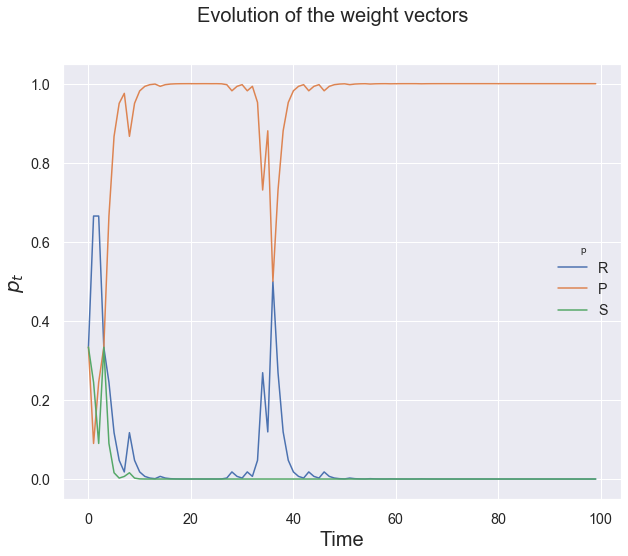

In [6]:
# (b)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the weight vectors', size = 20)
plt.plot(p_hist[:,0], label = 'R')
plt.plot(p_hist[:,1], label = 'P')
plt.plot(p_hist[:,2], label = 'S')
plt.xlabel('Time', size = 20)
plt.ylabel('$p_t$', size = 20)
plt.legend(title='p')

Text(0, 0.5, '$\\hat{\\mathcal{l}}_t$')

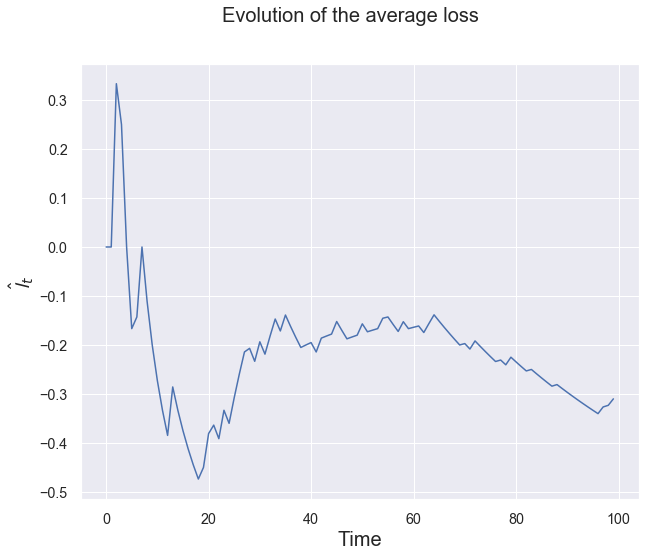

In [7]:
l_avg = np.zeros_like(l_hist)

for t in range(T):

  l_avg[t] = np.sum(l_hist[:t+1])/(t+1)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the average loss', size = 20)
plt.plot(l_avg)
plt.xlabel('Time', size = 20)
plt.ylabel('$\hat{\mathcal{l}}_t$', size = 20)

Text(0, 0.5, '$R_t$')

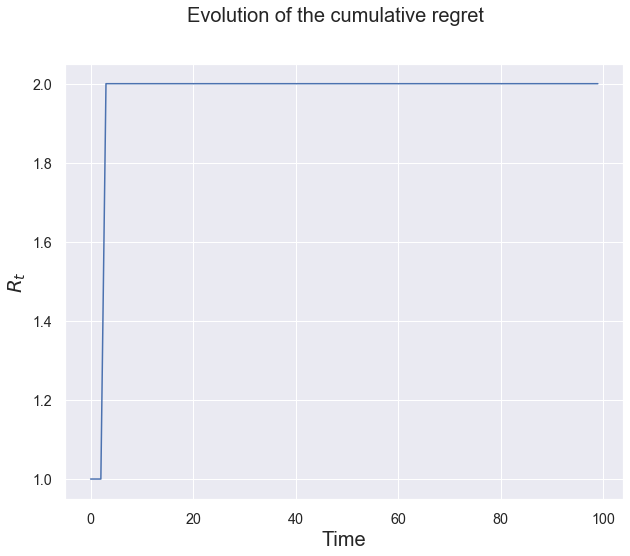

In [8]:
# (d)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the cumulative regret', size = 20)
plt.plot(cum_regret)
plt.xlabel('Time', size = 20)
plt.ylabel('$R_t$', size = 20)

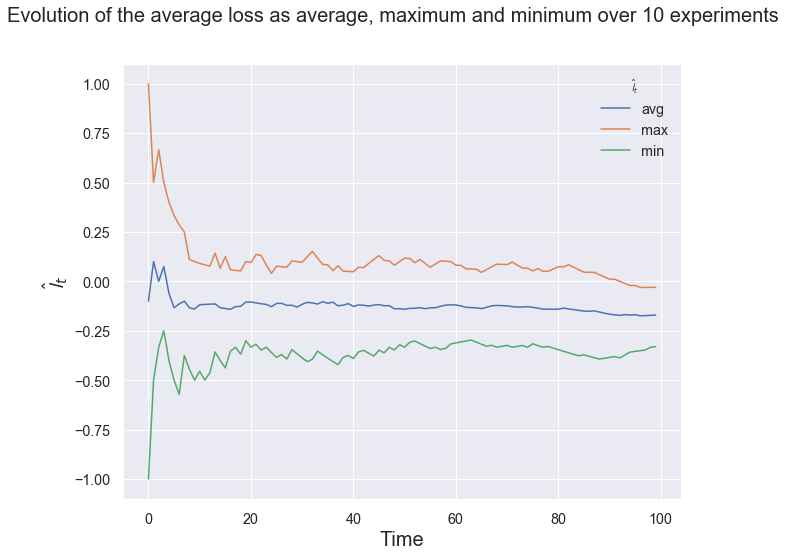

In [9]:
# (e)

n = 10

l_hist_n = np.zeros((n,T))

for i in range(n):
  
  _, l_hist_n[i,:], _ = EWA_fixed_adv(p0, T, eta, q, L_RPS)

l_avg_n = np.zeros_like(l_hist_n)

for t in range(T):

  l_avg_n[:,t] = np.sum(l_hist_n[:,:t+1], axis=1)/(t+1)

l_avg_n_avg = np.sum(l_avg_n, axis=0)/n

l_avg_n_max = np.amax(l_avg_n, axis=0)

l_avg_n_min = np.amin(l_avg_n, axis=0)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the average loss as average, maximum and minimum over ' + str(n) + ' experiments', size = 20)
plt.plot(l_avg_n_avg, label = 'avg')
plt.plot(l_avg_n_max, label = 'max')
plt.plot(l_avg_n_min, label = 'min')
plt.xlabel('Time', size = 20)
plt.ylabel('$\hat{\mathcal{l}}_t$', size = 20)
plt.legend(title='$\hat{\mathcal{l}}_t$')

Text(0, 0.5, '$R_T$')

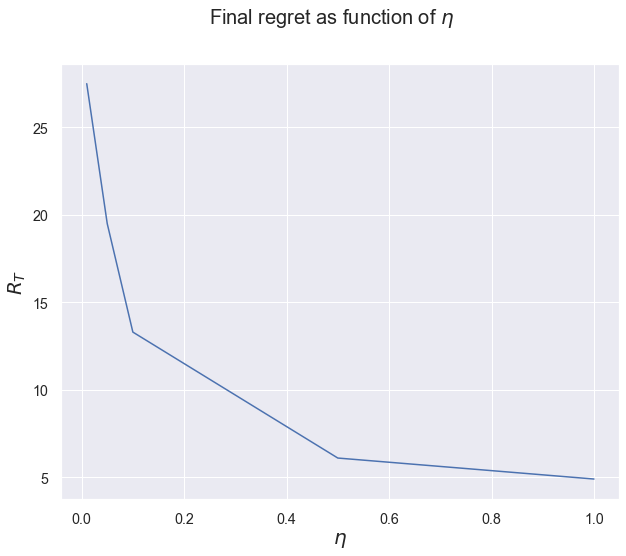

In [10]:
# (f)

etas = [0.01, 0.05, 0.1, 0.5, 1]

final_regret_eta = np.zeros((n,len(etas)))

for e in range(len(etas)):

  for i in range(n):
  
    final_regret_eta[i,e] = EWA_fixed_adv(p0, T, etas[e], q, L_RPS)[2][-1]

final_regret_eta_avg_n = np.sum(final_regret_eta, axis=0)/n

plt.figure(figsize=(10, 8))
plt.suptitle('Final regret as function of $\eta$', size = 20)
plt.plot(etas, final_regret_eta_avg_n)
plt.xlabel('$\eta$', size = 20)
plt.ylabel('$R_T$', size = 20)

### 4. Simulation against an adaptive adversary

In [11]:
# (a)

def EWA_EWA_adv(p0, T, eta, q0, eta_adv, L):
  """
  input: vector p_0 ∈ ∆_M, T, eta, vector q_O ∈ ∆_N, eta_adv and loss matrix L
  return: all vectors p_t ∈ ∆_M, all losses l_t and the cumulative regret R_T
  """
    
  p = np.copy(p0)
  q = np.copy(q0)
    
  p_hist = np.zeros((T,len(p0)))
  
  l_hist = np.zeros(T)

  l_hist_all_i = np.zeros((len(p0),T))
  cum_regret = np.zeros(T)
    
  p0 = p
  q0 = q
    
  for t in range(T):
    
    p_hist[t,:] = p
                
    i = rand_weighted(p)
    j = rand_weighted(q)
        
    l_hist[t] = L[i,j]

    cum_regret[t] = np.sum(l_hist) - np.amin(np.sum(l_hist_all_i, axis=1), axis=0)
        
    p = EWA_update(p, np.reshape(L[:,j],(len(p0))), eta)
    q = EWA_update(q, np.reshape(L[i,:],(len(p0))), eta_adv)
        
  return p_hist, l_hist, cum_regret

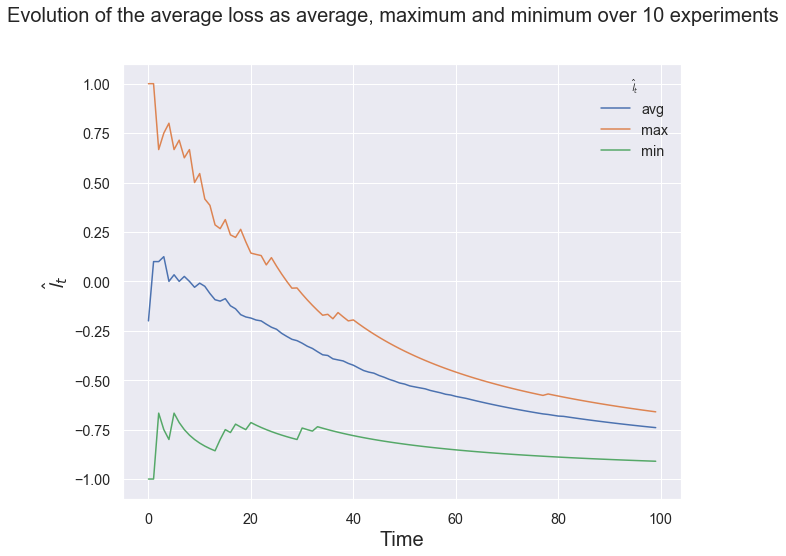

In [12]:
eta_adv = 0.05

q0 = (1/3)*np.ones(3)

l_hist_adv_n = np.zeros((n,T))

for i in range(n):
  
  _, l_hist_adv_n[i,:], _ = EWA_EWA_adv(p0, T, eta, q0, eta_adv, L_RPS)

l_adv_avg_n = np.zeros_like(l_hist_n)

for t in range(T):

  l_adv_avg_n[:,t] = np.sum(l_hist_adv_n[:,:t+1], axis=1)/(t+1)

l_adv_avg_n_avg = np.sum(l_adv_avg_n, axis=0)/n

l_adv_avg_n_max = np.amax(l_adv_avg_n, axis=0)

l_adv_avg_n_min = np.amin(l_adv_avg_n, axis=0)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the average loss as average, maximum and minimum over ' + str(n) + ' experiments', size = 20)
plt.plot(l_adv_avg_n_avg, label = 'avg')
plt.plot(l_adv_avg_n_max, label = 'max')
plt.plot(l_adv_avg_n_min, label = 'min')
plt.xlabel('Time', size = 20)
plt.ylabel('$\hat{\mathcal{l}}_t$', size = 20)
plt.legend(title='$\hat{\mathcal{l}}_t$')

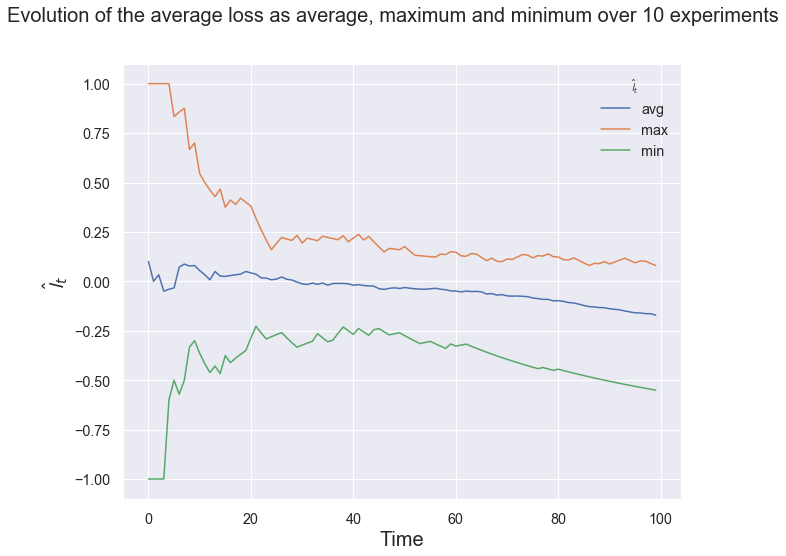

In [13]:
eta_adv = 0.05

q0 = (1/3)*np.ones(3)

l_hist_adv_n = np.zeros((n,T))

for i in range(n):
  
  _, l_hist_adv_n[i,:], _ = EWA_EWA_adv(p0, T, eta_adv, q0, eta_adv, L_RPS)

l_adv_avg_n = np.zeros_like(l_hist_n)

for t in range(T):

  l_adv_avg_n[:,t] = np.sum(l_hist_adv_n[:,:t+1], axis=1)/(t+1)

l_adv_avg_n_avg = np.sum(l_adv_avg_n, axis=0)/n

l_adv_avg_n_max = np.amax(l_adv_avg_n, axis=0)

l_adv_avg_n_min = np.amin(l_adv_avg_n, axis=0)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the average loss as average, maximum and minimum over ' + str(n) + ' experiments', size = 20)
plt.plot(l_adv_avg_n_avg, label = 'avg')
plt.plot(l_adv_avg_n_max, label = 'max')
plt.plot(l_adv_avg_n_min, label = 'min')
plt.xlabel('Time', size = 20)
plt.ylabel('$\hat{\mathcal{l}}_t$', size = 20)
plt.legend(title='$\hat{\mathcal{l}}_t$')

(10000,)


Text(0.5, 0, 'Time')

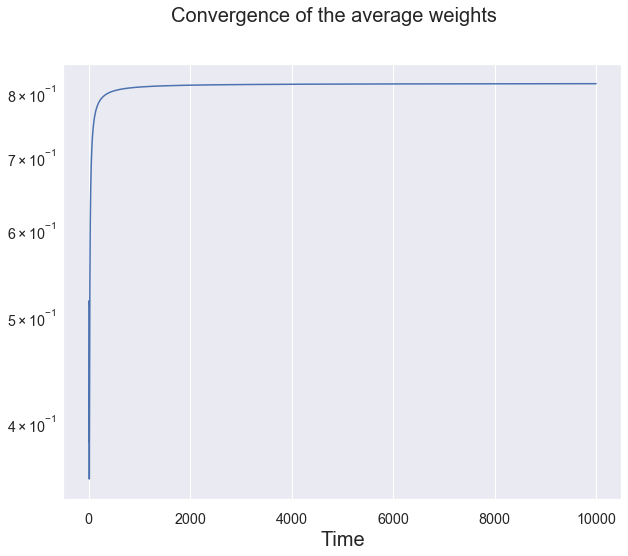

In [14]:
# (b)

p_hist_large, _, _ = EWA_EWA_adv(np.random.rand(3), 10000, eta, np.random.rand(3), eta_adv, L_RPS)

p_avg = np.zeros_like(p_hist_large)

for t in range(10000):

  p_avg[t,:] = np.sum(p_hist_large[:t+1,:], axis=0)/(t+1)

p_conv = np.linalg.norm(p_avg - (1/3) * np.ones_like(p_avg), axis=1)

print(p_conv.shape)

plt.figure(figsize=(10, 8))
plt.suptitle('Convergence of the average weights', size = 20)
plt.plot(p_conv)
plt.semilogy()
plt.xlabel('Time', size = 20)

(10000,)


Text(0.5, 0, 'Time')

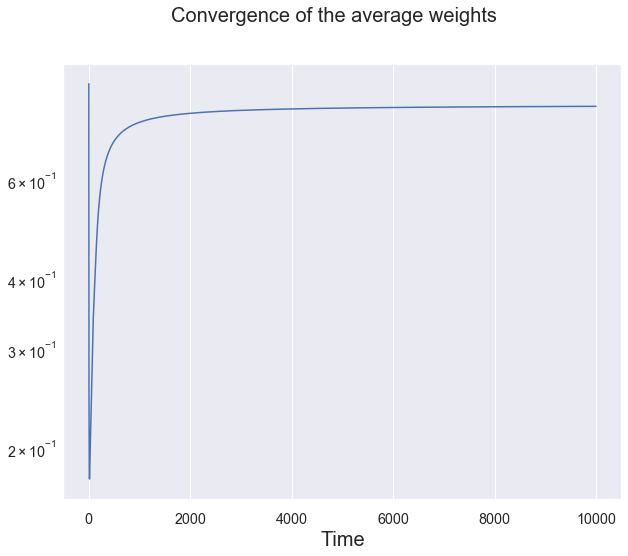

In [15]:
# (b)

p_hist_large, _, _ = EWA_EWA_adv(np.random.rand(3), 10000, eta_adv, np.random.rand(3), eta_adv, L_RPS)

p_avg = np.zeros_like(p_hist_large)

for t in range(10000):

  p_avg[t,:] = np.sum(p_hist_large[:t+1,:], axis=0)/(t+1)

p_conv = np.linalg.norm(p_avg - (1/3) * np.ones_like(p_avg), axis=1)

print(p_conv.shape)

plt.figure(figsize=(10, 8))
plt.suptitle('Convergence of the average weights', size = 20)
plt.plot(p_conv)
plt.semilogy()
plt.xlabel('Time', size = 20)

### 5. Implementation of EXP3

In [16]:
# (a)

def estimated_loss(i, l, p):
  """
  input: action i_t ∈ [M] played at round t ≥ 1, the loss L(i_t, j_t) and vector p_t ∈ ∆M
  return: vector of estimated loss \hat{l}_t ∈ R_+^M used by EXP3.
  """

  est_l = np.zeros(len(p))

  est_l[i] = l/p[i]

  return est_l


In [17]:
# (b)

def EXP3_update(p, i, l, eta):
  """
  input: vector p_t ∈ ∆M, action i_t ∈ [M] played at round t ≥ 1, the loss L(i_t, j_t) and eta
  return: vector p_{t+1} ∈ ∆M
  """

  est_l = estimated_loss(i, l, p)

  p_new = np.exp(-eta*est_l)*p
  p_new /= np.sum(p_new)

  return p_new

### 6.

In [18]:
# (a)

def EXP3_fixed_adv(p0, T, eta, q, L):
  """
  input: vector p_0 ∈ ∆_M, T, eta, vector q ∈ ∆_N and loss matrix L
  return: all vectors p_t ∈ ∆_M, all losses l_t and the cumulative regret R_T
  """
    
  p = np.copy(p0)
    
  p_hist = np.zeros((T,len(p0)))
  l_hist = np.zeros(T)

  l_hist_all_i = np.zeros((len(p0),T))
  cum_regret = np.zeros(T)
    
  p0 = p
    
  for t in range(T):
    
    p_hist[t,:] = p
                
    i = rand_weighted(p)
    j = rand_weighted(q)
        
    l_hist[t] = L[i,j]

    l_hist_all_i[:,t] = L[:,j]
    cum_regret[t] = np.sum(l_hist) - np.amin(np.sum(l_hist_all_i, axis=1), axis=0)
        
    p = EXP3_update(p, i, L[i,j], eta)
        
  return p_hist, l_hist, cum_regret

In [19]:
L_RPS_new = np.array([[1/2, 1, 0], [0, 1/2, 1], [1, 0, 1/2]])

T = 100
eta = 1

p0 = (1/3)*np.ones(3)
q = np.array([1/2, 1/4, 1/4])

p_hist, l_hist, cum_regret = EXP3_fixed_adv(p0, T, eta, q, L_RPS_new)

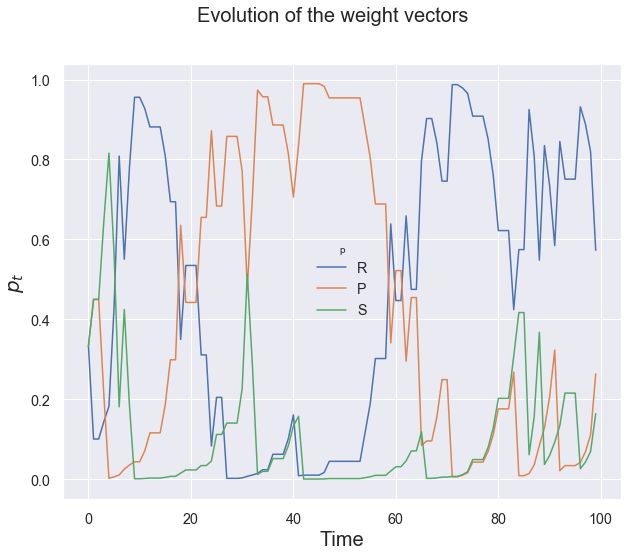

In [20]:
# (b)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the weight vectors', size = 20)
plt.plot(p_hist[:,0], label = 'R')
plt.plot(p_hist[:,1], label = 'P')
plt.plot(p_hist[:,2], label = 'S')
plt.xlabel('Time', size = 20)
plt.ylabel('$p_t$', size = 20)
plt.legend(title='p')

Text(0, 0.5, '$\\hat{\\mathcal{l}}_t$')

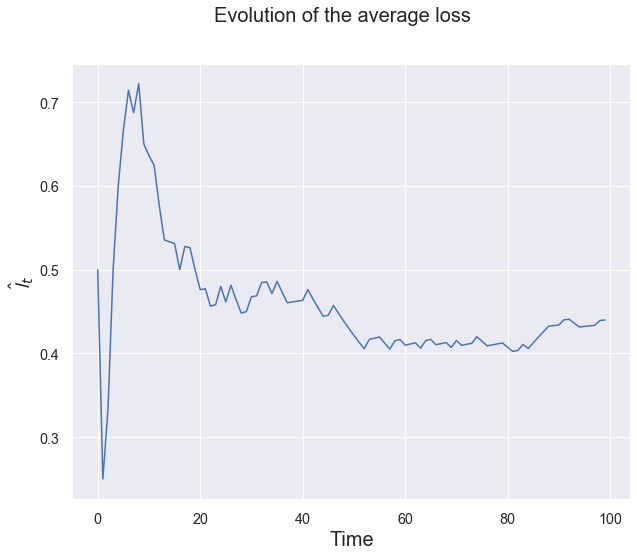

In [21]:
l_avg = np.zeros_like(l_hist)

for t in range(T):

  l_avg[t] = np.sum(l_hist[:t+1])/(t+1)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the average loss', size = 20)
plt.plot(l_avg)
plt.xlabel('Time', size = 20)
plt.ylabel('$\hat{\mathcal{l}}_t$', size = 20)

Text(0, 0.5, '$R_t$')

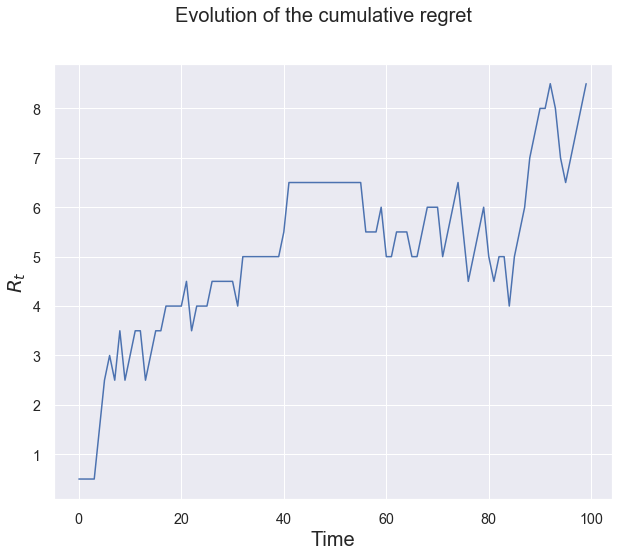

In [22]:
# (d)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the cumulative regret', size = 20)
plt.plot(cum_regret)
plt.xlabel('Time', size = 20)
plt.ylabel('$R_t$', size = 20)

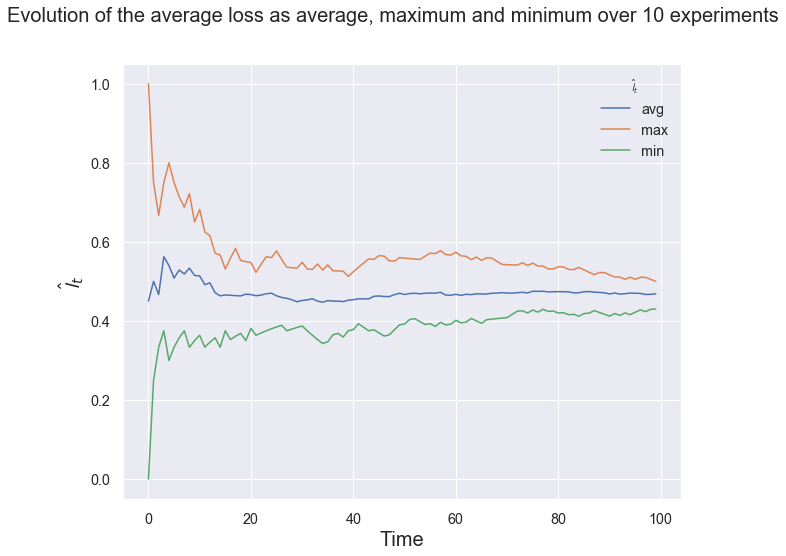

In [23]:
# (e)

n = 10

l_hist_n = np.zeros((n,T))

for i in range(n):
  
  _, l_hist_n[i,:], _ = EXP3_fixed_adv(p0, T, eta, q, L_RPS_new)

l_avg_n = np.zeros_like(l_hist_n)

for t in range(T):

  l_avg_n[:,t] = np.sum(l_hist_n[:,:t+1], axis=1)/(t+1)

l_avg_n_avg = np.sum(l_avg_n, axis=0)/n

l_avg_n_max = np.amax(l_avg_n, axis=0)

l_avg_n_min = np.amin(l_avg_n, axis=0)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the average loss as average, maximum and minimum over ' + str(n) + ' experiments', size = 20)
plt.plot(l_avg_n_avg, label = 'avg')
plt.plot(l_avg_n_max, label = 'max')
plt.plot(l_avg_n_min, label = 'min')
plt.xlabel('Time', size = 20)
plt.ylabel('$\hat{\mathcal{l}}_t$', size = 20)
plt.legend(title='$\hat{\mathcal{l}}_t$')

Text(0, 0.5, '$R_T$')

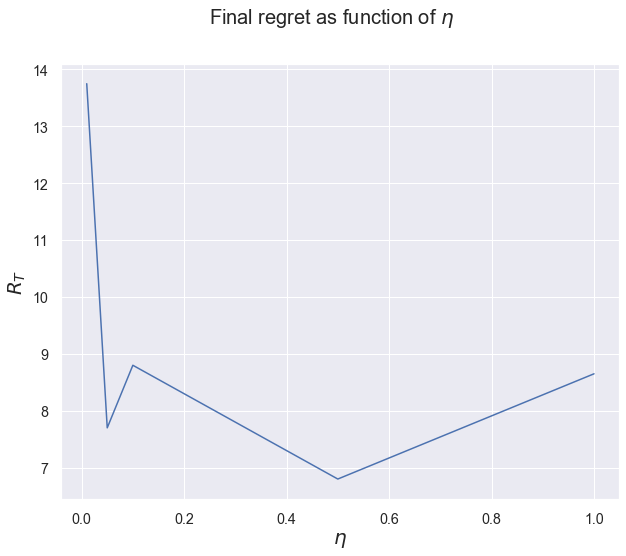

In [24]:
# (f)

etas = [0.01, 0.05, 0.1, 0.5, 1]

final_regret_eta = np.zeros((n,len(etas)))

for e in range(len(etas)):

  for i in range(n):
  
    final_regret_eta[i,e] = EXP3_fixed_adv(p0, T, etas[e], q, L_RPS_new)[2][-1]

final_regret_eta_avg_n = np.sum(final_regret_eta, axis=0)/n

plt.figure(figsize=(10, 8))
plt.suptitle('Final regret as function of $\eta$', size = 20)
plt.plot(etas, final_regret_eta_avg_n)
plt.xlabel('$\eta$', size = 20)
plt.ylabel('$R_T$', size = 20)

### 7.

In [25]:
# (a)

def EXP3_EWA_adv(p0, T, eta, q0, eta_adv, L):
  """
  input: vector p_0 ∈ ∆_M, T, eta, vector q_O ∈ ∆_N, eta_adv and loss matrix L
  return: all vectors p_t ∈ ∆_M, all losses l_t and the cumulative regret R_T
  """
    
  p = np.copy(p0)
  q = np.copy(q0)
    
  p_hist = np.zeros((T,len(p0)))
  
  l_hist = np.zeros(T)

  l_hist_all_i = np.zeros((len(p0),T))
  cum_regret = np.zeros(T)
    
  p0 = p
  q0 = q
    
  for t in range(T):
    
    p_hist[t,:] = p
                
    i = rand_weighted(p)
    j = rand_weighted(q)
        
    l_hist[t] = L[i,j]

    l_hist_all_i[:,t] = L[:,j]
    cum_regret[t] = np.sum(l_hist) - np.amin(np.sum(l_hist_all_i, axis=1), axis=0)
        
    p = EXP3_update(p, i, L[i,j], eta)
    q = EWA_update(q, np.reshape(L[i,:],(len(p0))), eta_adv)
        
  return p_hist, l_hist, cum_regret

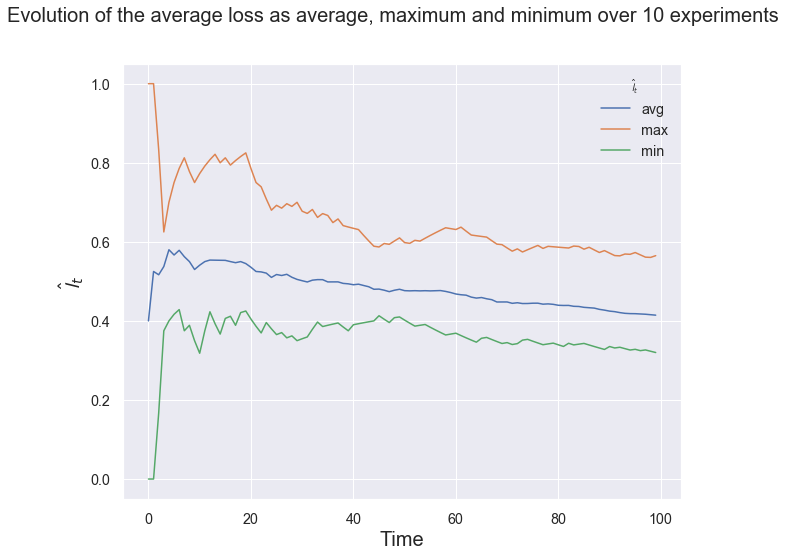

In [26]:
eta_adv = 0.05

q0 = (1/3)*np.ones(3)

l_hist_adv_n = np.zeros((n,T))

for i in range(n):
  
  _, l_hist_adv_n[i,:], _ = EXP3_EWA_adv(p0, T, eta, q0, eta_adv, L_RPS_new)

l_adv_avg_n = np.zeros_like(l_hist_n)

for t in range(T):

  l_adv_avg_n[:,t] = np.sum(l_hist_adv_n[:,:t+1], axis=1)/(t+1)

l_adv_avg_n_avg = np.sum(l_adv_avg_n, axis=0)/n

l_adv_avg_n_max = np.amax(l_adv_avg_n, axis=0)

l_adv_avg_n_min = np.amin(l_adv_avg_n, axis=0)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the average loss as average, maximum and minimum over ' + str(n) + ' experiments', size = 20)
plt.plot(l_adv_avg_n_avg, label = 'avg')
plt.plot(l_adv_avg_n_max, label = 'max')
plt.plot(l_adv_avg_n_min, label = 'min')
plt.xlabel('Time', size = 20)
plt.ylabel('$\hat{\mathcal{l}}_t$', size = 20)
plt.legend(title='$\hat{\mathcal{l}}_t$')

(10000,)


Text(0.5, 0, 'Time')

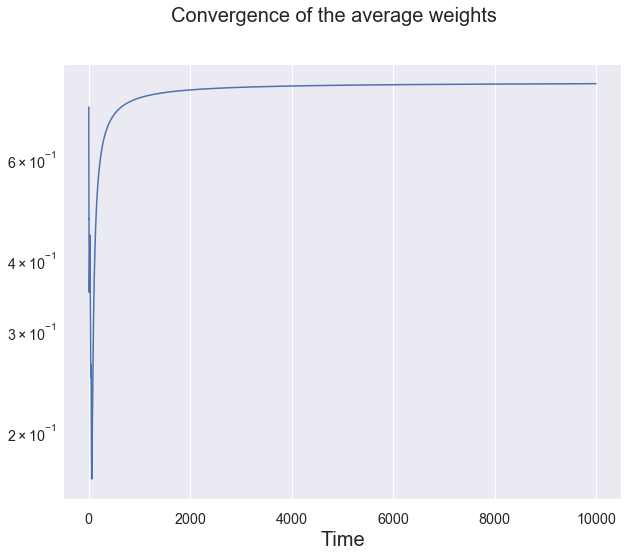

In [27]:
# (b)

p_hist_large, _, _ = EXP3_EWA_adv(np.random.rand(3), 10000, eta, np.random.rand(3), eta_adv, L_RPS_new)

p_avg = np.zeros_like(p_hist_large)

for t in range(10000):

  p_avg[t,:] = np.sum(p_hist_large[:t+1,:], axis=0)/(t+1)

p_conv = np.linalg.norm(p_avg - (1/3) * np.ones_like(p_avg), axis=1)

print(p_conv.shape)

plt.figure(figsize=(10, 8))
plt.suptitle('Convergence of the average weights', size = 20)
plt.plot(p_conv)
plt.semilogy()
plt.xlabel('Time', size = 20)

### 8.

In [28]:
# (a)

def mu(X, k, m):
  """
  input: matrix X of gains at each time and for each choice, k ∈ [M], m
  return: mu the approx expectation of gain for k ∈ [M] until m
  """

  K = X.shape[1]
  mu = np.sum(X[:int(m*K),k])
  mu /= m

  return mu

def UCB(N, X, t):
  """
  input: vector N of number of times each choice has been picked,
  matrix X of gains at each time and for each choice and time t
  return: j ∈ [M] the play as argmax of upper bounds
  """

  UCB = np.zeros_like(N)

  for k in range(len(N)):

    if N[k]==0:
      UCB[k] = float("inf")

    else:
      UCB[k] = mu(X, k, N[k]) + np.sqrt((2*np.log(t+1))/N[k])

  j = np.argmax(UCB)

  return j


def EXP3_UCB_adv(p0, T, eta, L):
  """
  input: vector p_0 ∈ ∆_M, T, eta and loss matrix L
  return: all vectors p_t ∈ ∆_M, all losses l_t and the cumulative regret R_T
  """
    
  p = np.copy(p0)
    
  p_hist = np.zeros((T,len(p0)))
  
  l_hist = np.zeros(T)

  X_hist = np.zeros((T,len(p0)))
  N = np.zeros(len(p0))

  l_hist_all_i = np.zeros((len(p0),T))
  cum_regret = np.zeros(T)
    
  p0 = p
    
  for t in range(T):
    
    p_hist[t,:] = p
                
    i = rand_weighted(p)

    j = UCB(N, X_hist, t)

    N[j] += 1
    X_hist[t,j] = L[i,j]
        
    l_hist[t] = L[i,j]

    l_hist_all_i[:,t] = L[:,j]
    cum_regret[t] = np.sum(l_hist) - np.amin(np.sum(l_hist_all_i, axis=1), axis=0)
        
    p = EXP3_update(p, i, L[i,j], eta)
        
  return p_hist, l_hist, cum_regret

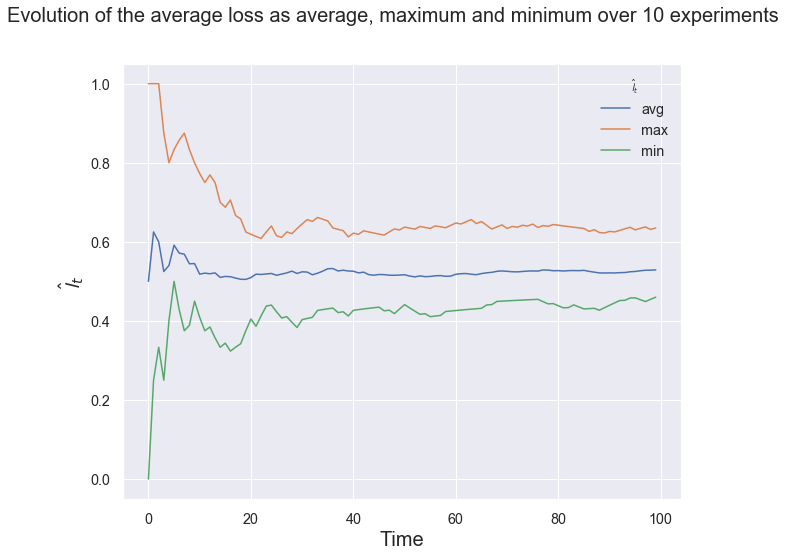

In [29]:
n=10

l_hist_adv_n = np.zeros((n,T))

for i in range(n):
  
  _, l_hist_adv_n[i,:], _ = EXP3_UCB_adv(p0, T, eta, L_RPS_new)

l_adv_avg_n = np.zeros((n,T))

for t in range(T):

  l_adv_avg_n[:,t] = np.sum(l_hist_adv_n[:,:t+1], axis=1)/(t+1)

l_adv_avg_n_avg = np.sum(l_adv_avg_n, axis=0)/n

l_adv_avg_n_max = np.amax(l_adv_avg_n, axis=0)

l_adv_avg_n_min = np.amin(l_adv_avg_n, axis=0)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the average loss as average, maximum and minimum over ' + str(n) + ' experiments', size = 20)
plt.plot(l_adv_avg_n_avg, label = 'avg')
plt.plot(l_adv_avg_n_max, label = 'max')
plt.plot(l_adv_avg_n_min, label = 'min')
plt.xlabel('Time', size = 20)
plt.ylabel('$\hat{\mathcal{l}}_t$', size = 20)
plt.legend(title='$\hat{\mathcal{l}}_t$')

(10000,)


Text(0.5, 0, 'Time')

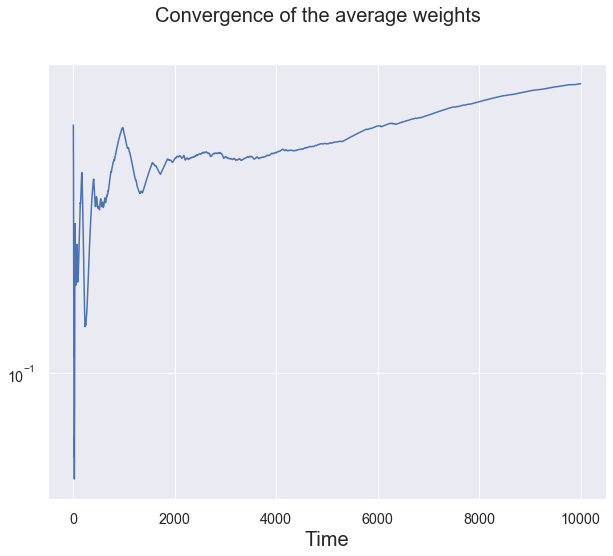

In [30]:
# (b)

p_hist_large, _, _ = EXP3_UCB_adv(np.random.rand(3), 10000, eta, L_RPS_new)

p_avg = np.zeros_like(p_hist_large)

for t in range(10000):

  p_avg[t,:] = np.sum(p_hist_large[:t+1,:], axis=0)/(t+1)

p_conv = np.linalg.norm(p_avg - (1/3) * np.ones_like(p_avg), axis=1)

print(p_conv.shape)

plt.figure(figsize=(10, 8))
plt.suptitle('Convergence of the average weights', size = 20)
plt.plot(p_conv)
plt.semilogy()
plt.xlabel('Time', size = 20)

### 9.

In [31]:
def EXP3_IX_fixed_adv(T, eta, gamma, q, L):
  """
  input: vector T, eta, gamma, vector q ∈ ∆_N and loss matrix L
  return: all vectors p_t ∈ ∆_M, all losses l_t and the cumulative regret R_T
  """
      
  p_hist = np.zeros((T,len(q)))
  l_hist = np.zeros(T)

  l_est = np.zeros(len(q))

  l_hist_all_i = np.zeros((len(p0),T))
  cum_regret = np.zeros(T)
      
  for t in range(T):

    p = np.exp(-eta*l_est)
    p /= np.sum(p)
    
    p_hist[t,:] = p
                
    i = rand_weighted(p)
    j = rand_weighted(q)
        
    l_hist[t] = L[i,j]

    l_hist_all_i[:,t] = L[:,j]
    cum_regret[t] = np.sum(l_hist) - np.amin(np.sum(l_hist_all_i, axis=1), axis=0)
        
    l_est[i] += L[i,j]/(p[i] + gamma)
        
  return p_hist, l_hist, cum_regret

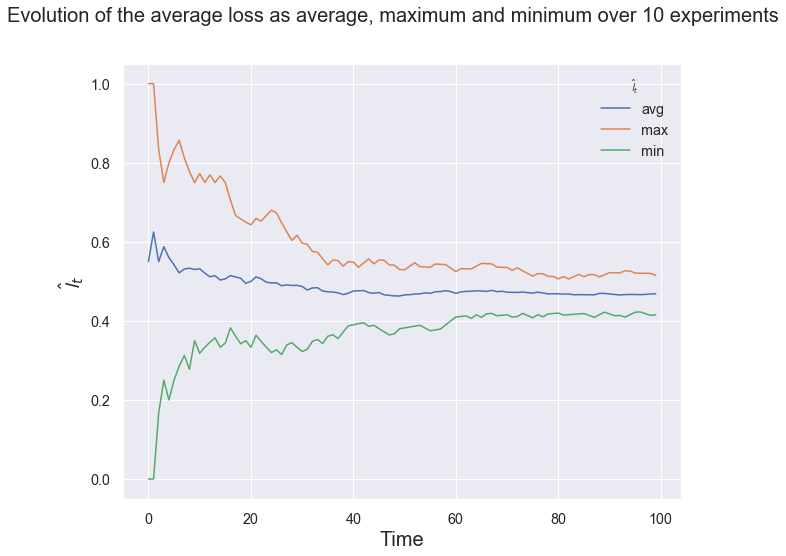

In [32]:
# (e)

n = 10

l_hist_n = np.zeros((n,T))

for i in range(n):
  
  _, l_hist_n[i,:], _ = EXP3_IX_fixed_adv(T, eta, eta/2, q, L_RPS_new)

l_avg_n = np.zeros_like(l_hist_n)

for t in range(T):

  l_avg_n[:,t] = np.sum(l_hist_n[:,:t+1], axis=1)/(t+1)

l_avg_n_avg = np.sum(l_avg_n, axis=0)/n

l_avg_n_max = np.amax(l_avg_n, axis=0)

l_avg_n_min = np.amin(l_avg_n, axis=0)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the average loss as average, maximum and minimum over ' + str(n) + ' experiments', size = 20)
plt.plot(l_avg_n_avg, label = 'avg')
plt.plot(l_avg_n_max, label = 'max')
plt.plot(l_avg_n_min, label = 'min')
plt.xlabel('Time', size = 20)
plt.ylabel('$\hat{\mathcal{l}}_t$', size = 20)
plt.legend(title='$\hat{\mathcal{l}}_t$')

### 10. Prisoner's dilemma

#### (a) Player plays EWA with $\eta=1$ and adversary plays EWA with $\eta=0.05$


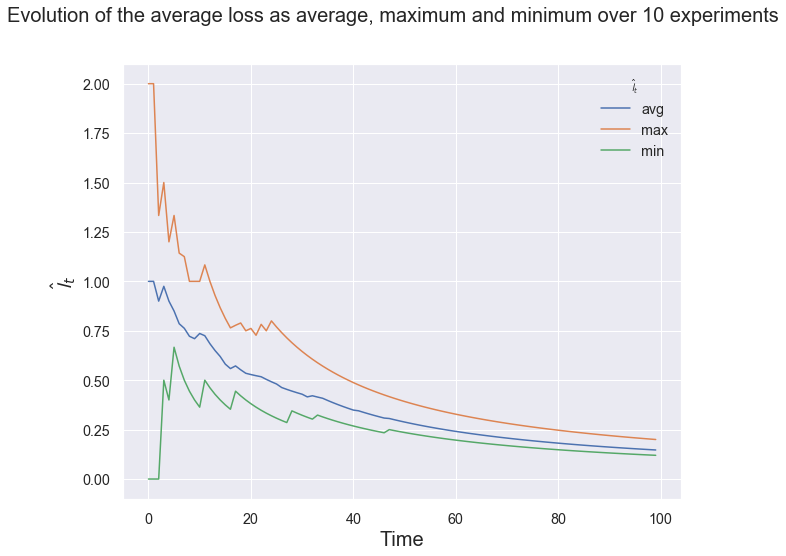

In [33]:
L_pris = np.array([[1, 3], [0, 2]])

T = 100
eta = 1

p0 = (1/2)*np.ones(2)

eta_adv = 0.05

q0 = (1/2)*np.ones(2)

l_hist_adv_n = np.zeros((n,T))

for i in range(n):
  
  _, l_hist_adv_n[i,:], _ = EWA_EWA_adv(p0, T, eta, q0, eta_adv, L_pris)

l_adv_avg_n = np.zeros_like(l_hist_n)

for t in range(T):

  l_adv_avg_n[:,t] = np.sum(l_hist_adv_n[:,:t+1], axis=1)/(t+1)

l_adv_avg_n_avg = np.sum(l_adv_avg_n, axis=0)/n

l_adv_avg_n_max = np.amax(l_adv_avg_n, axis=0)

l_adv_avg_n_min = np.amin(l_adv_avg_n, axis=0)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the average loss as average, maximum and minimum over ' + str(n) + ' experiments', size = 20)
plt.plot(l_adv_avg_n_avg, label = 'avg')
plt.plot(l_adv_avg_n_max, label = 'max')
plt.plot(l_adv_avg_n_min, label = 'min')
plt.xlabel('Time', size = 20)
plt.ylabel('$\hat{\mathcal{l}}_t$', size = 20)
plt.legend(title='$\hat{\mathcal{l}}_t$')

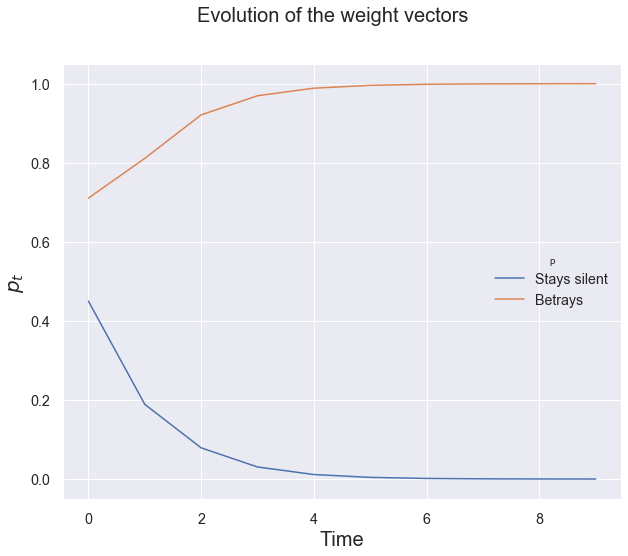

In [34]:
p_hist_large, _, _ = EWA_EWA_adv(np.random.rand(2), 10, eta, np.random.rand(2), eta_adv, L_pris)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the weight vectors', size = 20)
plt.plot(p_hist_large[:,0], label = 'Stays silent')
plt.plot(p_hist_large[:,1], label = 'Betrays')
plt.xlabel('Time', size = 20)
plt.ylabel('$p_t$', size = 20)
plt.legend(title='p')

(10000,)


Text(0.5, 0, 'Time')

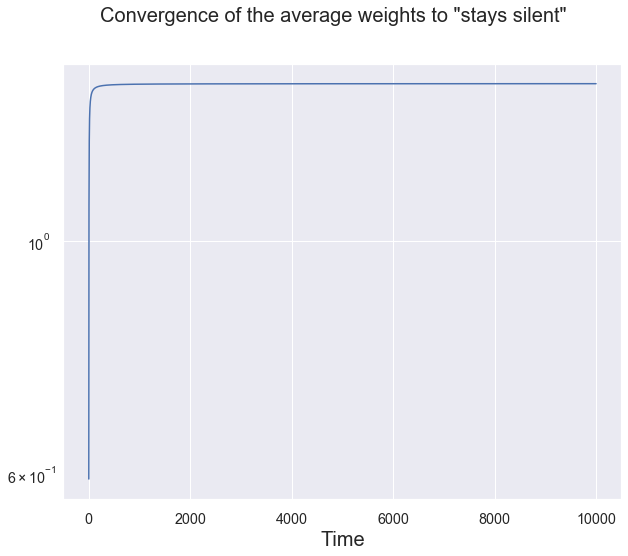

In [35]:
p_hist_large, _, _ = EWA_EWA_adv(np.random.rand(2), 10000, eta, np.random.rand(2), eta_adv, L_pris)

p_avg = np.zeros_like(p_hist_large)

for t in range(10000):

  p_avg[t,:] = np.sum(p_hist_large[:t+1,:], axis=0)/(t+1)

p_conv = np.linalg.norm(p_avg - np.array([1, 0]), axis=1)

print(p_conv.shape)

plt.figure(figsize=(10, 8))
plt.suptitle('Convergence of the average weights to "stays silent"', size = 20)
plt.plot(p_conv)
plt.semilogy()
plt.xlabel('Time', size = 20)

(10000,)


Text(0.5, 0, 'Time')

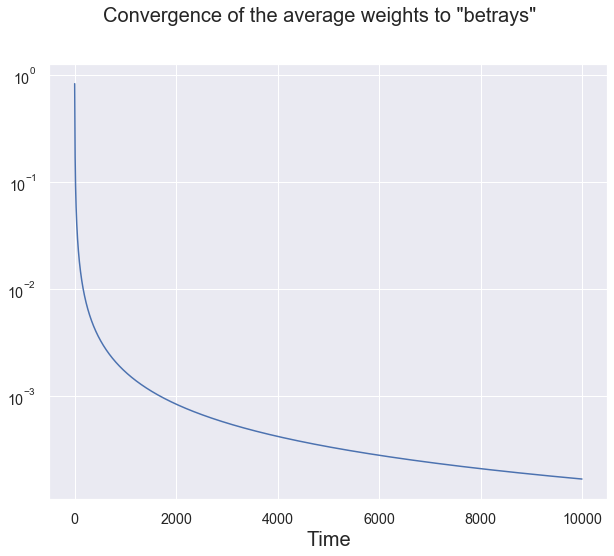

In [36]:
p_avg = np.zeros_like(p_hist_large)

for t in range(10000):

  p_avg[t,:] = np.sum(p_hist_large[:t+1,:], axis=0)/(t+1)

p_conv = np.linalg.norm(p_avg - np.array([0, 1]), axis=1)

print(p_conv.shape)

plt.figure(figsize=(10, 8))
plt.suptitle('Convergence of the average weights to "betrays"', size = 20)
plt.plot(p_conv)
plt.semilogy()
plt.xlabel('Time', size = 20)

#### (b) Player plays EXP3 with $\eta=1$ and adversary plays EWA with $\eta=0.05$

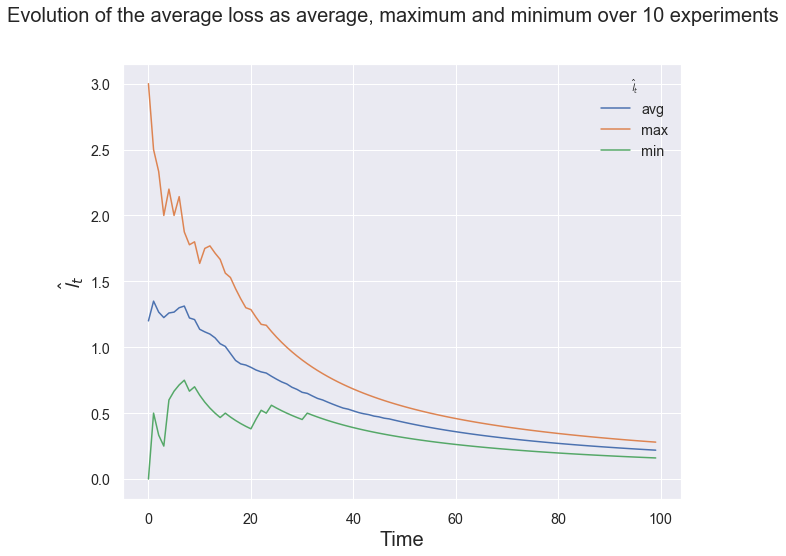

In [37]:
eta_adv = 0.05

q0 = (1/2)*np.ones(2)

l_hist_adv_n = np.zeros((n,T))

for i in range(n):
  
  _, l_hist_adv_n[i,:], _ = EXP3_EWA_adv(p0, T, eta, q0, eta_adv, L_pris)

l_adv_avg_n = np.zeros_like(l_hist_n)

for t in range(T):

  l_adv_avg_n[:,t] = np.sum(l_hist_adv_n[:,:t+1], axis=1)/(t+1)

l_adv_avg_n_avg = np.sum(l_adv_avg_n, axis=0)/n

l_adv_avg_n_max = np.amax(l_adv_avg_n, axis=0)

l_adv_avg_n_min = np.amin(l_adv_avg_n, axis=0)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the average loss as average, maximum and minimum over ' + str(n) + ' experiments', size = 20)
plt.plot(l_adv_avg_n_avg, label = 'avg')
plt.plot(l_adv_avg_n_max, label = 'max')
plt.plot(l_adv_avg_n_min, label = 'min')
plt.xlabel('Time', size = 20)
plt.ylabel('$\hat{\mathcal{l}}_t$', size = 20)
plt.legend(title='$\hat{\mathcal{l}}_t$')

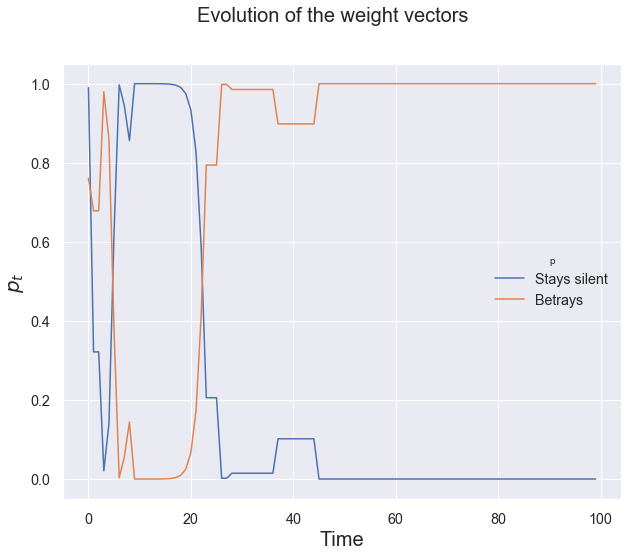

In [38]:
p_hist_large, _, _ = EXP3_EWA_adv(np.random.rand(2), 100, eta, np.random.rand(2), eta_adv, L_pris)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the weight vectors', size = 20)
plt.plot(p_hist_large[:,0], label = 'Stays silent')
plt.plot(p_hist_large[:,1], label = 'Betrays')
plt.xlabel('Time', size = 20)
plt.ylabel('$p_t$', size = 20)
plt.legend(title='p')

(10000,)


Text(0.5, 0, 'Time')

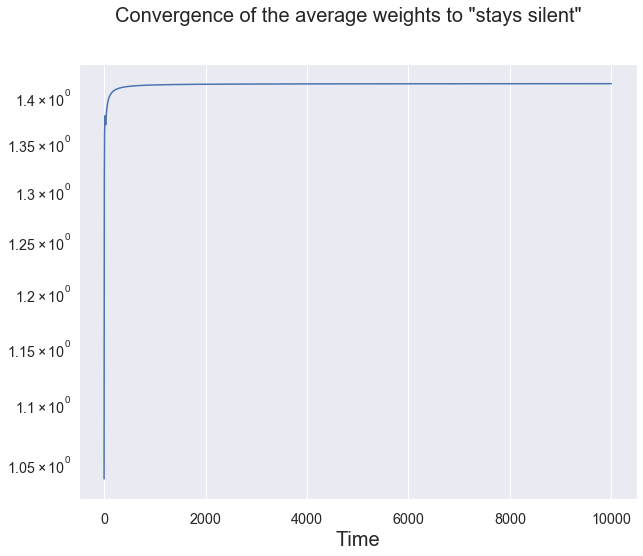

In [39]:
p_hist_large, _, _ = EXP3_EWA_adv(np.random.rand(2), 10000, eta, np.random.rand(2), eta_adv, L_pris)


p_avg = np.zeros_like(p_hist_large)

for t in range(10000):

  p_avg[t,:] = np.sum(p_hist_large[:t+1,:], axis=0)/(t+1)

p_conv = np.linalg.norm(p_avg - np.array([1, 0]), axis=1)

print(p_conv.shape)

plt.figure(figsize=(10, 8))
plt.suptitle('Convergence of the average weights to "stays silent"', size = 20)
plt.plot(p_conv)
plt.semilogy()
plt.xlabel('Time', size = 20)

(10000,)


Text(0.5, 0, 'Time')

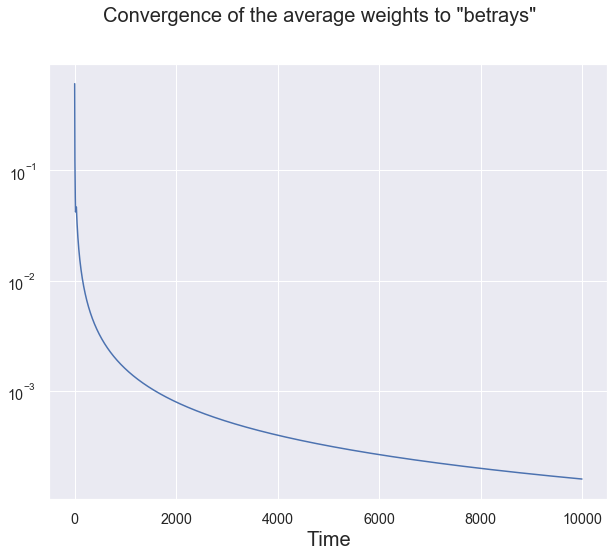

In [40]:
p_avg = np.zeros_like(p_hist_large)

for t in range(10000):

  p_avg[t,:] = np.sum(p_hist_large[:t+1,:], axis=0)/(t+1)

p_conv = np.linalg.norm(p_avg - np.array([0, 1]), axis=1)

print(p_conv.shape)

plt.figure(figsize=(10, 8))
plt.suptitle('Convergence of the average weights to "betrays"', size = 20)
plt.plot(p_conv)
plt.semilogy()
plt.xlabel('Time', size = 20)

#### (c) Player plays EXP3 with $\eta=1$ and adversary plays UCB

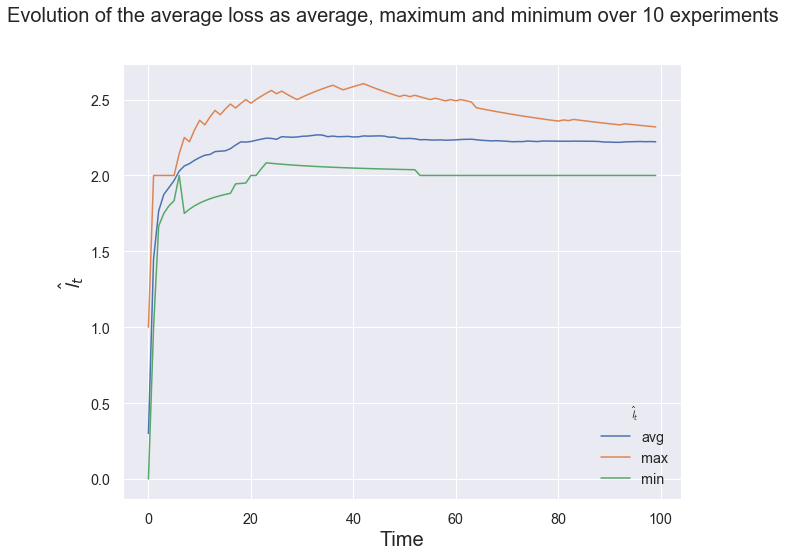

In [41]:
n=10

l_hist_adv_n = np.zeros((n,T))

for i in range(n):
  
  _, l_hist_adv_n[i,:], _ = EXP3_UCB_adv(p0, T, eta, L_pris)

l_adv_avg_n = np.zeros((n,T))

for t in range(T):

  l_adv_avg_n[:,t] = np.sum(l_hist_adv_n[:,:t+1], axis=1)/(t+1)

l_adv_avg_n_avg = np.sum(l_adv_avg_n, axis=0)/n

l_adv_avg_n_max = np.amax(l_adv_avg_n, axis=0)

l_adv_avg_n_min = np.amin(l_adv_avg_n, axis=0)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the average loss as average, maximum and minimum over ' + str(n) + ' experiments', size = 20)
plt.plot(l_adv_avg_n_avg, label = 'avg')
plt.plot(l_adv_avg_n_max, label = 'max')
plt.plot(l_adv_avg_n_min, label = 'min')
plt.xlabel('Time', size = 20)
plt.ylabel('$\hat{\mathcal{l}}_t$', size = 20)
plt.legend(title='$\hat{\mathcal{l}}_t$')

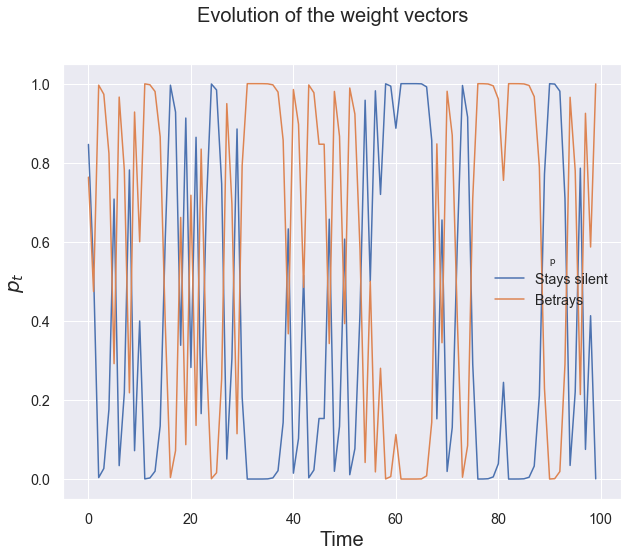

In [42]:
p_hist_large, _, _ = EXP3_UCB_adv(np.random.rand(2), 100, eta, L_pris)

plt.figure(figsize=(10, 8))
plt.suptitle('Evolution of the weight vectors', size = 20)
plt.plot(p_hist_large[:,0], label = 'Stays silent')
plt.plot(p_hist_large[:,1], label = 'Betrays')
plt.xlabel('Time', size = 20)
plt.ylabel('$p_t$', size = 20)
plt.legend(title='p')

(10000,)


Text(0.5, 0, 'Time')

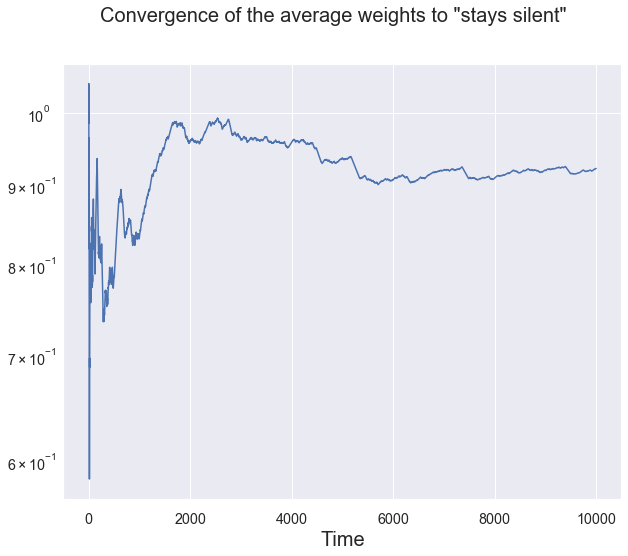

In [43]:
p_hist_large, _, _ = EXP3_UCB_adv(np.random.rand(2), 10000, eta, L_pris)

p_avg = np.zeros_like(p_hist_large)

for t in range(10000):

  p_avg[t,:] = np.sum(p_hist_large[:t+1,:], axis=0)/(t+1)

p_conv = np.linalg.norm(p_avg - np.array([1, 0]), axis=1)

print(p_conv.shape)

plt.figure(figsize=(10, 8))
plt.suptitle('Convergence of the average weights to "stays silent"', size = 20)
plt.plot(p_conv)
plt.semilogy()
plt.xlabel('Time', size = 20)

(10000,)


Text(0.5, 0, 'Time')

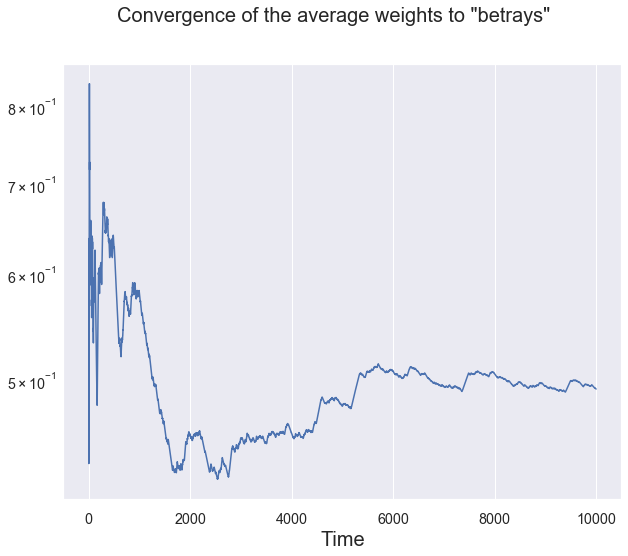

In [44]:
p_avg = np.zeros_like(p_hist_large)

for t in range(10000):

  p_avg[t,:] = np.sum(p_hist_large[:t+1,:], axis=0)/(t+1)

p_conv = np.linalg.norm(p_avg - np.array([0, 1]), axis=1)

print(p_conv.shape)

plt.figure(figsize=(10, 8))
plt.suptitle('Convergence of the average weights to "betrays"', size = 20)
plt.plot(p_conv)
plt.semilogy()
plt.xlabel('Time', size = 20)

# Part 3. Experiments - predict votes of surveys
In these experiments, we will apply online convex optimization algorithms to pairwise comparison datasets. Comparison data arises in many different applications such as sport competition, recommender systems or web clicks. We consider the following sequential setting. Let $\mathcal{Z}=\{1, \ldots, N\}$ be a finite set of items (for example football teams in a competition).


At each iteration $t \geq 1$,
  - the learner receives the labels of two items that are competing $z_{t}=\left(z_{t}(1), z_{t}(2)\right) \in \mathcal{Z}^{2}$ 
  - the learner predicts $\hat{y}_{t} \in(0,1)$ the probability of victory of item $z_{t}(1)$
  - the environment reveals the result of the match $y_{t}=1$ if item $z_{t}(1)$ wins the match and $y_{t}=0$ otherwise (if team $z_{f}(2)$ wins)
The learner aims at minimizing his cumulative loss: $\hat{L}_{T}=\sum_{t=1}^{T} \ell\left(\hat{y}_{t}, y_{t}\right),$ where $\ell\left(\hat{y}_{t}, y_{t}\right)=\left(1-\hat{y}_{t}\right) y_{t}+\hat{y}_{t}\left(1-y_{t}\right)$

The **datasets** contain two files:
- ideas-id.csv (resp. politicans-id.csv) that contains id and text of the ideas (resp. political figures).
- ideas-votes.csv (resp. politicians-votes.csv) that contains the id of the two competing ideas (resp. political figures) in $z 1$ and $z 2$ and a column $y$ which is 1 if the participant voted for $z 1$ and 0 otherwise. 

The goal of the learner is to sequentially predict the results of the votes minimizing the number of mistakes.

In [45]:
ideas_id = pd.read_csv("ideas_id.csv")
ideas_votes = pd.read_csv("ideas_votes.csv")

In [46]:
K, n_col = ideas_id.shape
T, n_col = ideas_votes.shape
y = ideas_votes['y']
print("number of ideas: ",K)
print("number of votes: ",T)

number of ideas:  261
number of votes:  15000


## Sleeping strategies

In [47]:
def f1(data, K, t,p):
  """
  Sleeping strategy
  Input:
  -----
  data: dataset containing the competing items
  K: number of items
  t: round t (t in {1,...,T})
  p: weigthing vector
  Output:
  ------
  f: experts predictions
  y_t: prediction for round t
  """
  f_t = [1, 0, 0, 1]
  p = p[[data["z1"][t]-1,data["z1"][t]-1+K,data["z2"][t]-1,data["z2"][t]-1+K]]
  p = p/np.sum(p)
  y_t = np.sum(f_t*p)

  f = np.zeros(2*K)
  for k in range(K):
    if data["z1"][t] == k+1:
      f[k], f[k+K] = 1, 0
    elif data["z2"][t] == k+1:
      f[k], f[k+K] = 0, 1
    else: 
      f[k], f[k+K] = np.round(y_t), np.round(y_t)
  return f, y_t

## The Exponentially weighted average forecaster (EWA)

In [48]:
def EWA(eta, f1, K, y, T, data):
  """
  Exponentially weighted average forecaster
  Input:
  -----
  eta:
  gt:
  T: Horizon
  K: actions
  Output:
  ------
  p: weighting vector
  loss: expected loss for each t in {1,...,T}
  true_loss: true loss for each t in {1,...,T}
  y_pred: predictions of votes
  """

  #initialization
  p = 1/(2*K) * np.ones(2*K)
  loss = [0]
  y_pred = []
  true_loss = [0]
  for t in range(T):
    #if t% 1000== 0:
    #  print("############ iteration " + str(t) + " ############" )
    #  print("cumulative loss", np.cumsum(loss)[-1])
    f, y_t = f1(data, K, t, p)
    y_pred.append(np.round(y_t))
    gt = (1-f)*y[t] + f*(1-y[t])
    loss.append((1-y_t)*y[t] + y_t*(1-y[t]))
    true_loss.append((1-np.round(y_t))*y[t] + 
                     np.round(y_t)*(1-y[t]))

    renorm = np.sum(p*np.exp(-eta*gt))
    p = p*np.exp(-eta*gt)/renorm
  return p, loss,true_loss, y_pred

## Online Gradient Descent (OGD)

In [49]:
def OGD(eta, f1, T, K, y, data):
  """
  Exponentially weighted average forecaster
  Input:
  -----
  eta:
  ft:
  T: Horizon
  Output:
  ------
  theta = weighting vector
  """
  theta = 1/(2*K) * np.ones(2*K)
  loss = [0]
  true_loss = [0]
  y_pred = []
  for t in range(T):
    f, y_t = f1(data, K, t, theta)
    y_pred.append(np.round(y_t))
    loss.append((1-y_t)*y[t] + y_t*(1-y[t]))
    true_loss.append((1-np.round(y_t))*y[t] + np.round(y_t)*(1-y[t]))
    grad = (-y[t] + 1)*theta
    norm = theta[[data["z1"][t]-1,data["z1"][t]-1+K,
                  data["z2"][t]-1,data["z2"][t]-1+K]]
    norm = np.sum(norm)
    theta = (theta - eta*grad)/norm
  return theta, loss, true_loss, y_pred

# Plot functions

In [58]:
def plt_eta(etas, dataset, save = False):
  """
  Input:
  -----
  etas: (list) 
        list containing different values of eta 
  dataset: dataset to be used
  save: (bool) if True, we save the plt
  """
  fig = plt.figure()

  for i, eta in enumerate(etas):
    p, loss, true_loss, y_pred = EWA(eta, f1, K, y,
                          15000, dataset)
    print("score for $\eta=$"+ str(eta), np.sum(y_pred == y)/len(y))
    plt.plot(np.linspace(1,len(loss),15001),np.cumsum(loss),
            label = "$\eta = $ "+ str(eta))
    plt.title("Evolution of the cumulative loss")
    plt.xlabel("Iteration")
    plt.ylabel("Cumulative loss")
  plt.legend()
  plt.tight_layout()
  if save : 
    plt.savefig("comparison_loss_etas.png")
    plt.savefig("comparison_loss_etas.pdf")
  plt.show()

In [61]:
def plot_cumloss(loss, loss_name):
  cumsum = np.cumsum(loss)
  avg_loss= [1/t * cumsum[t-1] for t in range(1, 15000 )]

  plt.plot(np.linspace(1,len(cumsum),14999),avg_loss)
  plt.title("Evolution of the "+ str(loss_name))
  plt.xlabel("Iteration")
  plt.ylabel(str(loss_name))
  plt.show()

## ploting our results for the **ideas dataset** 

In [53]:
ideas_id = pd.read_csv("ideas_id.csv")
ideas_votes = pd.read_csv("ideas_votes.csv")

In [54]:
K, n_col = ideas_id.shape
T, n_col = ideas_votes.shape
y = ideas_votes['y']
print("number of ideas: ",K)
print("number of votes: ",T)

number of ideas:  261
number of votes:  15000


In [55]:
p, loss,true_loss, y_pred = EWA(0.5, f1, K, y, 15000, ideas_votes)

### Plot of the cumulative loss for different eta

score for $\eta=$0.01 0.6252
score for $\eta=$0.1 0.6246666666666667
score for $\eta=$0.3 0.626
score for $\eta=$0.5 0.6226


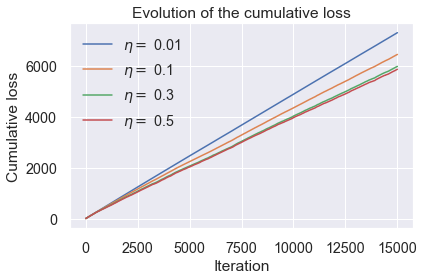

In [59]:
etas = [0.01, 0.1, 0.3, 0.5]
plt_eta(etas, ideas_votes)

### Plot of the average expected loss 

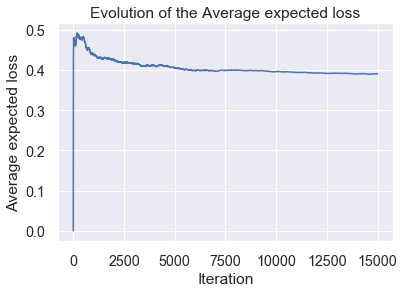

In [62]:
plot_cumloss(loss, "Average expected loss")

### Plot of the true average loss

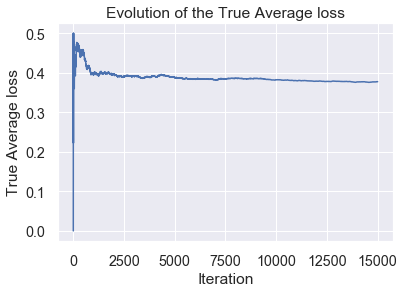

In [63]:
plot_cumloss(true_loss, "True Average loss")

## ploting our results for the **politicians dataset** 

In [64]:
politicians_id = pd.read_csv("politicians_id.csv")
politicians_votes = pd.read_csv("politicians_votes.csv")
K, n_col = politicians_id.shape
T, n_col = politicians_votes.shape
y = politicians_votes['y']
print(K)
print(T)

39
15000


In [65]:
p, loss,true_loss, y_pred = EWA(0.5, f1, K, y, 15000, politicians_votes)

### Plot of the cumulative loss for different eta

score for $\eta=$0.01 0.6886666666666666
score for $\eta=$0.1 0.6852666666666667
score for $\eta=$0.3 0.6862
score for $\eta=$0.5 0.6858


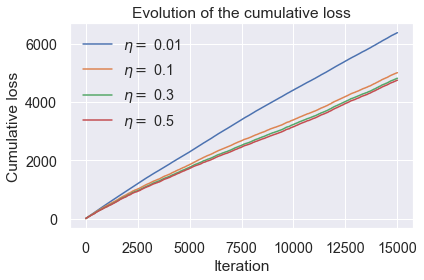

In [68]:
etas = [0.01, 0.1, 0.3, 0.5]
plt_eta(etas, politicians_votes)

### Plot of the average expected loss 

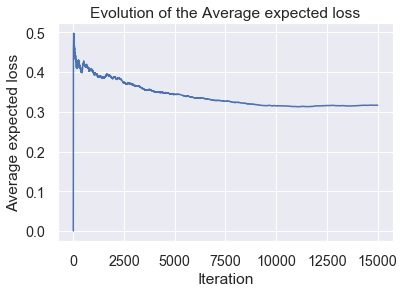

In [69]:
plot_cumloss(loss, "Average expected loss")

### Plot of the true average loss

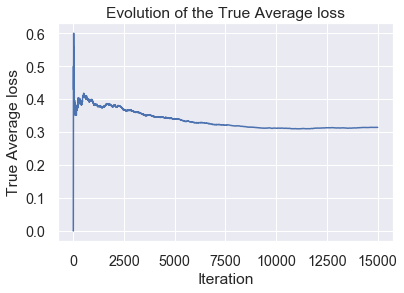

In [70]:
plot_cumloss(true_loss, "True Average loss")